In [1]:
import pandas as pd
from io import StringIO
from pathlib import Path
from urllib.request import urlopen

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## Read files from Harvard Dataverse

In [2]:
url = "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/WMGPGZ/HY6N2S"
file = urlopen(url).readlines()

## Clean datasets

In [3]:
# fix dataset corruption/incorrect line break/incorrect quotation mark
for i in range(len(file)):
    file[i] = file[i].decode("utf-8").lstrip('"').rstrip(';\r\n')
for i in [84,86,342,370,433,435,436,457,609,628,696,799,947,957,1030,1134,1534,1537,1938]:
    file[i] = file[i].replace('."', '."",""') + file[i+1].lstrip(',')
    del file[i+1]
for i in range(len(file)):
    file[i] = file[i][:-1]
for i in range(1, len(file)):
    file[i] = file[i].replace('""""', '"')
for i in range(1,4):
    file[i] = file[i].replace("\xa0", "")

In [4]:
# create a sep sign "",""
file[0] = '""' + file[0].rstrip('""')
for i in range(1, 10):
    file[i] = file[i][:1] + '""' + file[i][1:-5] + '""' + file[i][-5:-4] + '""' + file[i][-4:-3] + '""' +\
              file[i][-3:-2] + '""' + file[i][-2:-1] + '""' + file[i][-1:]
for i in range(10, 100):
    file[i] = file[i][:2] + '""' + file[i][2:-5] + '""' + file[i][-5:-4] + '""' + file[i][-4:-3] + '""' +\
              file[i][-3:-2] + '""' + file[i][-2:-1] + '""' + file[i][-1:]
for i in range(100, 1000):
    file[i] = file[i][:3] + '""' + file[i][3:-5] + '""' + file[i][-5:-4] + '""' + file[i][-4:-3] + '""' +\
              file[i][-3:-2] + '""' + file[i][-2:-1] + '""' + file[i][-1:]
for i in range(1000, len(file)):
    file[i] = file[i][:4] + '""' + file[i][4:-5] + '""' + file[i][-5:-4] + '""' + file[i][-4:-3] + '""' +\
              file[i][-3:-2] + '""' + file[i][-2:-1] + '""' + file[i][-1:]

In [5]:
# read the repaired dataframe
df = pd.read_csv(StringIO('\n'.join(file)), sep='"",""', engine='python')
df = df.drop(["Unnamed: 0", "inclusion_code"], axis=1)

In [6]:
# add labels and sort
df = df.rename(columns={"included": "label_included"})
df = df.rename(columns={"abstract_included": "label_abstract_screening"})
df = df.sort_values(by=["label_included", "label_abstract_screening"], ascending=False).reset_index(drop=True)

In [7]:
# remove duplicates
df_title = df["title"].str.replace("[^A-Za-z0-9]", "", regex=True)
df = df[(~df_title.str.lower().duplicated()) | (df_title.isnull())].reset_index(drop=True)

In [8]:
# add record_id
df.insert(0, "record_id", df.index + 1)

## Export datasets

In [9]:
Path("output").mkdir(parents=True, exist_ok=True)
df.to_csv("output/Nagtegaal_2019.csv", index=False)

## Dataset statistics

In [10]:
n = len(df)
n_inc = df["label_included"].sum()
n_inc_abs = df["label_abstract_screening"].sum()
n_exc = n - n_inc
n_exc_abs = n - n_inc_abs
n_exc_full = n_inc_abs - n_inc

print("Number of papers with missing title:        ", df["title"].isna().sum(), "\n")
print("Number of papers with missing abstract:     ", df["abstract"].isna().sum(), "\n")
print("Total number of papers:                     ", n, "\n")
print("Total number of EXCLUSIONS:                 ", n_exc, "\n")
print("Total EXCLUSIONS after abstract screening:  ", n_exc_abs, "\n")
print("Total INCLUSIONS after abstract screening:  ", n_inc_abs, "\n")
print("Total EXCLUSIONS after full text screening: ", n_exc_full, "\n")
print("Total INCLUSIONS after full text screening: ", n_inc, " (", round(100*n_inc/n, 2), "% )\n")

Number of papers with missing title:         0 

Number of papers with missing abstract:      169 

Total number of papers:                      2008 

Total number of EXCLUSIONS:                  1907 

Total EXCLUSIONS after abstract screening:   1619 

Total INCLUSIONS after abstract screening:   389 

Total EXCLUSIONS after full text screening:  288 

Total INCLUSIONS after full text screening:  101  ( 5.03 % )



There are 212036 words in the combination of all titles. 

There are 3368397 words in the combination of all abstracts. 



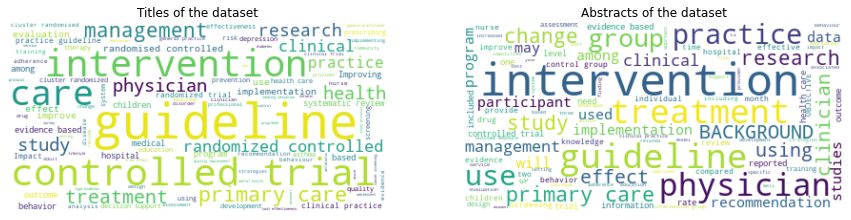

In [11]:
# word cloud for titles and abstracts
# create stopword list
stopwords = set(STOPWORDS)
stopwords.update(["patient", "patients", "method", "methods", "result", "results", "conclusion", "conclusions"])

# create word cloud text
title_text = " ".join(word for word in df.title.dropna())
abstract_text = " ".join(word for word in df.abstract.dropna())
print("There are {} words in the combination of all titles.".format(len(title_text)), "\n")
print("There are {} words in the combination of all abstracts.".format(len(abstract_text)), "\n")

# generate word cloud images
title_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(title_text)
abstract_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(abstract_text)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 15])
ax1.imshow(title_wordcloud, interpolation="bilinear")
ax1.set_title("Titles of the dataset")
ax1.axis("off")
ax2.imshow(abstract_wordcloud, interpolation="bilinear")
ax2.set_title("Abstracts of the dataset")
ax2.axis("off")
plt.show()